# Importing libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data loading and processing

In [7]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [9]:
df.size

9366

In [10]:
df.shape

(1338, 7)

In [12]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [13]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# Separating features and target variables


In [14]:
x = df.drop("charges", axis=1)
y = df["charges"]

# Defining Categorical and numerical columns

In [15]:
categorical_cols = ['sex','smoker', 'region']
numerical_cols = ['age', 'bmi', 'children']

# Creating Transformers

In [16]:
categorical_transformers = OneHotEncoder(drop=('first'))
numerical_transformers = StandardScaler()

# Column transformer

In [20]:
preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', numerical_transformers, numerical_cols),
        ('cat', categorical_transformers, categorical_cols)
    ])

# Creating Pipeline with a regression model

In [21]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Spliting the data

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)


# Fitting the model

In [23]:
model.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', LinearRegression())])

# Prediction and Evaluation

In [24]:
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test,y_pred)
print(f"Mean Squared Error:{mse:.2f}")

Mean Squared Error:33596915.85


In [25]:
print(df['charges'].describe())

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


# Import Libraries

In [28]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 

# feature Engineering(Interacting terms)


In [29]:
df['bmi_smoker'] = (df['smoker']=='yes').astype(int)
df['age_smoker'] = (df['smoker']=='yes').astype(int)

# Defining features and target

In [33]:
df['log_charges'] = np.log(df['charges'])
x = df.drop(columns=['charges','log_charges'])
y = df['log_charges']

# Columns Definitions

In [34]:
categorical_col = ['sex','smoker','region']
numerical_cols = ['age','bmi_smoker','children','bmi','age_smoker']

# Preprocessor

In [36]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(),numerical_cols),
    ('cat', OneHotEncoder(),categorical_cols)
])

# Train_test split

In [37]:
x_train,x_test,y_train,y_test = train_test_split (x,y,test_size=0.2,random_state=42)

# Ridge Regression with cross_validation

In [41]:
ridge_pipeline = Pipeline ([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])
ridge_params={'model__alpha':[0.01,0.1,1,10,100]}
ridge_cv=GridSearchCV(ridge_pipeline,ridge_params,cv=5)
ridge_cv.fit(x_train,y_train)
ridge_preds=ridge_cv.best_estimator_.predict(x_test)
ridge_rmse=np.sqrt(mean_squared_error(np.exp(y_test),np.exp(ridge_preds)))
print(f"Ridge RMSE:{ridge_rmse:.2f}")

Ridge RMSE:7715.78


# Lasso Regression with cross_validation

In [45]:
lasso_pipeline=Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso(max_iter=10000))
])
lasso_params={'model__alpha':[0.01,0.1,1,10]}
lasso_cv=GridSearchCV(lasso_pipeline,lasso_params,cv=5)
lasso_cv.fit(x_train,y_train)
lasso_preds=lasso_cv.best_estimator_.predict(x_test)
lasso_rmse=np.sqrt(mean_squared_error(np.exp(y_test),np.exp(lasso_preds)))
print(f"Lasso RMSE:{lasso_rmse:2f}")

Lasso RMSE:7556.741669


# Random Forest

In [50]:
rf_pipeline=Pipeline([
    ('preprocessor', preprocessor),
    ('model',RandomForestRegressor(n_estimators=100,random_state=42))
])
rf_pipeline.fit(x_train,y_train)
rf_preds=rf_pipeline.predict(x_test)
rf_rmse=np.sqrt(mean_squared_error(np.exp(y_test),np.exp(rf_preds)))
print(f"RandomForest RMSE:{rf_rmse:.2f}")

RandomForest RMSE:4396.40


# XGBoost

In [55]:
xgb_pipeline=Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=100,learning_rate=0.1,random_state=42))    
])
xgb_pipeline.fit(x_train,y_train)
xgb_pred=xgb_pipeline.predict(x_test)
xgb_rmse=np.sqrt(mean_squared_error(np.exp(y_test), np.exp(xgb_pred)))
print(f"XGBoost RMSE:{xgb_rmse:.2f}")

XGBoost RMSE:4435.99


# visualized predictions from the best model (Random Forest)

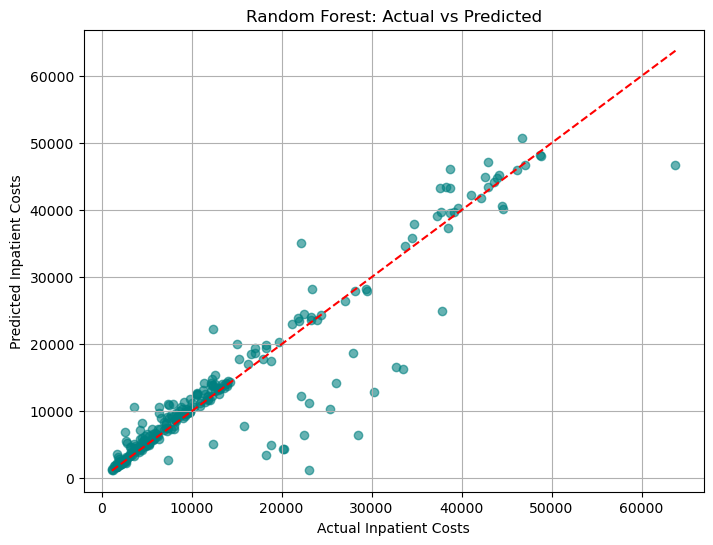

In [56]:
plt.figure(figsize=(8, 6))
plt.scatter(np.exp(y_test), np.exp(rf_preds), alpha=0.6, color='teal')
plt.plot([np.min(np.exp(y_test)), np.max(np.exp(y_test))],
         [np.min(np.exp(y_test)), np.max(np.exp(y_test))],
         color='red', linestyle='--')
plt.xlabel("Actual Inpatient Costs")
plt.ylabel("Predicted Inpatient Costs")
plt.title("Random Forest: Actual vs Predicted")
plt.grid(True)
plt.show()

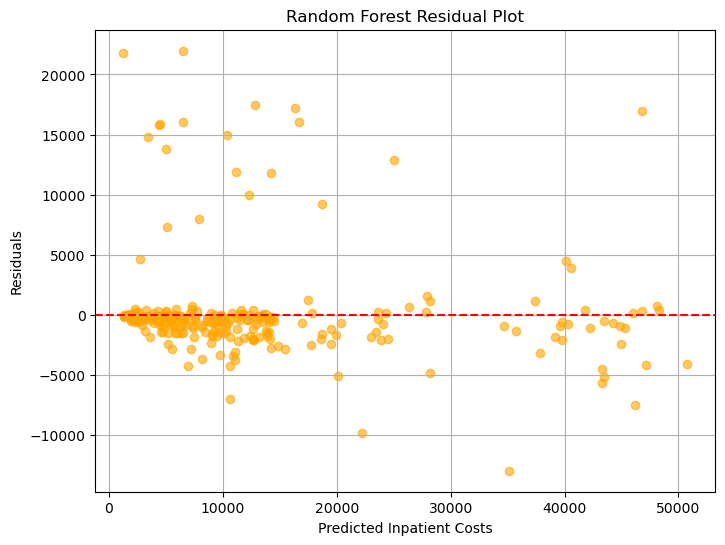

In [57]:
residuals = np.exp(y_test) - np.exp(rf_preds)

plt.figure(figsize=(8, 6))
plt.scatter(np.exp(rf_preds), residuals, alpha=0.6, color='orange')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Inpatient Costs")
plt.ylabel("Residuals")
plt.title("Random Forest Residual Plot")
plt.grid(True)
plt.show()

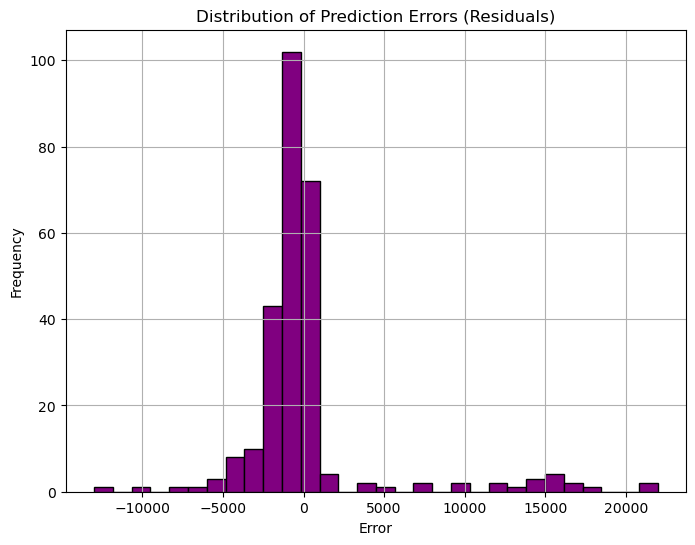

In [58]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='purple', edgecolor='black')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()